# 1. Initial Analysis:

In [1]:
### for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%run "~/Python/Jupyter/Functions/detect_peaks.py"
%run "~/Python/Jupyter/Functions/my_functions.py"
#nice stylesheet for dark theme notebook\
import matplotlib.pyplot as plt
plt.style.use(['ggplot'])
#plt.style.use(['dark_background'])
 
# iPython magic for interactive plots
# %matplotlib widget

import os, pathlib  
import neurodot_data
from neurodot_data import configurator
import numpy as np
import seaborn as sns
import matplotlib as mpl
import math as m
import scipy as sp
from scipy import signal
from scipy.ndimage import shift
import pandas as pd
from scipy.signal import find_peaks, find_peaks_cwt
import pickle as pk
from scipy.spatial import distance
import collections
import pywt
import sklearn as sk
from sklearn.svm import SVC

# Turn off warning messages:
import warnings
warnings.filterwarnings('ignore')
# Quite often it is useful to see a warning once. This can be set by:
# warnings.filterwarnings(action='once')
# you change it back to 'default' See: docs.python.org/2/library/warnings.html

from scipy.signal import welch
 
def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

from scipy.fftpack import fft
import numpy as np
import matplotlib.pyplot as plt

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

In [ ]:
cd C:\Users\alibs\NeuroFieldzDev Dropbox\NeurodataAnalysis\neurofieldz2\2019-11-26_Tufts_mfVEP_monocular_m14_interleaved_subsequences

In [ ]:
path         = r"C:\Users\alibs\NeuroFieldzDev Dropbox\NeurodataAnalysis\neurofieldz2\2019-11-26_Tufts_mfVEP_monocular_m14_interleaved_subsequences"

config_ff    = os.path.join(path, "config_ffVEP.py") # path + r"\config_ffVEP.py"
config_mf    = os.path.join(path, "config_mfVEP36in60.py") # path + r"\config_mfVEP.py" # _LRB
TEST         = r"2022-06-13-SN001_ABJ-36secMono_OnlyRing4_wGlasses"
main_path    = os.path.join(path, "datasets", TEST) # path + r"\datasets\\" + TEST
results_path = os.path.join(main_path, "postprocessing")



# Subject Info:
condition  = 'Mask Experiment' #Healthy  #Multiple Sclerosis #Optic Neuritis #ON-Neurosarcoidosis-Cataract (Glasses)
experiment = TEST[17:]
date       = TEST[:10]


# Make a directory for saving plots:
try:
    os.mkdir(results_path)
except FileExistsError:
    print("Note: 'postprocessing' folder already exists.")


SESSION_PATH = pathlib.Path(main_path)

# CONFIG_PATH_ff  = pathlib.Path(config_ff)
CONFIG_PATH_mf  = pathlib.Path(config_mf)


EEG_SCALE_MICROVOLTS = 1e-6

config_mf = configurator.load_abspath_config(CONFIG_PATH_mf)
print("\n".join(name for name in dir(config_mf) if not name.startswith("__")))


# - - - - - - - - - - - - -
#    Overload Settings    :
# - - - - - - - - - - - - -

# # # MULTI FOCAL - - - - - - - - - - - - - - - :
# # ANALYSIS:
config_mf.AnalysisSettings.DEBUG_PLOTS_INTERACTIVE = False

# artifact reduction with wavelets
config_mf.AnalysisSettings.USE_BASELINE_SWT_FILTER = True
config_mf.AnalysisSettings.BASELINE_SWT_FILT_LEVEL = 9
config_mf.AnalysisSettings.BASELINE_SWT_WAVELET = "db8"
    
config_mf.AnalysisSettings.USE_SWT_SMOOTH_FILT = True
config_mf.AnalysisSettings.SWT_SMOOTH_FILT_LEVEL = 5
config_mf.AnalysisSettings.SWT_SMOOTH_FILT_WAVELET = "db8"
config_mf.AnalysisSettings.SWT_SMOOTH_FILT_UPSAMPLE_RATE = 1.0#25 #gives effective level between 4 and 5

# Bessel IIR bandpass filters
config_mf.AnalysisSettings.USE_NEURODATA_BANDPASS_FILTER = True
     
config_mf.AnalysisSettings.NEURODATA_BANDPASS_FILTER_LOW_CUTOFF   = 3.0  #Hz
config_mf.AnalysisSettings.NEURODATA_BANDPASS_FILTER_HIGH_CUTOFF  = 50.0 #Hz 100
    
config_mf.AnalysisSettings.USE_NEURODATA_LOWPASS_FILTER = False #True
config_mf.AnalysisSettings.NEURODATA_LOWPASS_FILTER_CUTOFF = 50.0 #Hz


# # VISUALIZATION:
config_mf.VisualizationSettings.DEBUG_PLOTS_INTERACTIVE = False
# artifact reduction with wavelets
config_mf.VisualizationSettings.USE_SWT_SMOOTH_FILT = True
config_mf.VisualizationSettings.USE_SWT_SMOOTH_FILT_FOR_ALPHA_OUTLIER_REJECTION = True
config_mf.VisualizationSettings.SWT_SMOOTH_FILT_LEVEL = 5
config_mf.VisualizationSettings.SWT_SMOOTH_FILT_WAVELET = "db8"
    
# trial based artifact rejection
config_mf.VisualizationSettings.USE_VARIANCE_OUTLIER_REJECTION   = True#True#True
config_mf.VisualizationSettings.USE_HIGH_ALPHA_OUTLIER_REJECTION = False#True#True
    
#ALPHA_FREQ = 11.0                 #this will eventually be estimated from data
config_mf.VisualizationSettings.ALPHA_FREQ = None                  #compute from spectral data
config_mf.VisualizationSettings.ALPHA_WINDOW_FUNC = np.hanning     #this must be a function(len) that returns array-like
config_mf.VisualizationSettings.ALPHA_KERNEL_DURATION = 1.0        #best guess for shortest "long blink", seconds
config_mf.VisualizationSettings.ALPHA_CORR_ENVELOP_FREQ_CUT = 5.0  #configures lowpass for alpha correlation envelope computation
config_mf.VisualizationSettings.ALPHA_OUTLIERS_FRACTION = 0.4      #main parameter for SciKit Learn outlier detection API
config_mf.VisualizationSettings.ALPHA_OUTLIERS_AECM_SIGMA = -0.5   #defines what is a "high" alpha threshold in terms of std from mean of AECM metric

In [ ]:
# ---------------------
# MULTI FOCAL ANALYSIS:
# ---------------------
plt.style.use(['ggplot'])
# Specify and load the analysis module from MFVEP paradigm plug-in:
modpath = "{}.analysis".format(config_mf.AnalysisSettings.PARADIGM)
mod = configurator.chain_import(modpath)
AP = mod.DataProcess(session_path=str(SESSION_PATH),config=config_mf)

# Run the analysis phase, which should produce session_path/mfvep/measurements.pkl
# NOTE may take a while to run, and only needs to be re-run if the config.AnalysisSettings are changed
AP.process()

In [ ]:
# MULTI FOCAL:

# Specify and load the visualization module from MFVEP paradigm plug-in
modpath = "{}.visualization".format(config_mf.VisualizationSettings.PARADIGM)
mod = configurator.chain_import(modpath)
VP_mf = mod.DataProcess(session_path=str(SESSION_PATH),config=config_mf)

# Run the processing code
# NOTE that the file session_path/mfvep/measurements.pkl is needed
VP_mf.process()

In [7]:
%matplotlib inline
# ----------------------------------------------------------- #

# 1. Calculating axis locations for Pie Grids  >> 36 SECTORS  #

# ----------------------------------------------------------- #

#
# 1.1. 36 SECTORS 
#
width  = 0.3
height = 0.3
r_init = 0.3
r_inc  = 0.47
n_sec = 36 # No. of sectors

axis_locs_36 = [[]]*n_sec # Locations & dimensions of axis
for i in range(4):
    theta = 45 - (90*i)
    r = r_init # for 1st ring
    axis_locs_36[[i][0]] = [r * m.cos(m.radians(theta)), r * m.sin(m.radians(theta)), width, height] # [Left, Bottom, Width, Height]
    
for i in range(8):
    theta = 67.5 - (45*i)
    r = r_init + r_inc # for 2nd ring
    axis_locs_36[[i+4][0]] = [r * m.cos(m.radians(theta)), r * m.sin(m.radians(theta)), width, height]
    
for j in range(2):
    for i in range(12):
        theta = 75 - (30*i)
        r = r_init + r_inc*(j+2) # for 3rd to 6th ring
        axis_locs_36[[i+(12*(j+1))][0]] = [r * m.cos(m.radians(theta)), r * m.sin(m.radians(theta)), width, height]

# For Pies around plots:
ring1_sectors = [90] * 4
ring2_sectors = [45] * 8
ring3_sectors = [30] * 12

In [ ]:
exp           = 'm14'
l_exp         = 'left-m14' #'both-m14'# |  'both-m14_1'  |  'both-m14_2'  |  'both-m15'  | 'left-m14' | 'right-m14'
r_exp         = 'right-m14' #'both-m14'#
l_MD          = VP_mf.M['meas_groups'][l_exp]
r_MD          = VP_mf.M['meas_groups'][r_exp]
# l_ff          = VP_ff.M['left-full-dartboard']['MG']
# r_ff          = VP_ff.M['right-full-dartboard']['MG']
s_r           = VP_mf.M['ads_sample_rate']
resp_window   = [0, 150]   # 45, 150 [ms] [0, 105]
noise_window  = [320, 470]  # [325, 430] [ms]
snr_sig_win   = [45, 150]
snr_noise_win = [325, 430]
n_sec         = 36 # Number of sectors
# ff_trials     = len(VP_ff.M['left-full-dartboard']['valid_trial_mask'])
no_channels   = 8

# 2. M U L T I   F O C A L:
# ----
# LEFT:
# ----
# L1. VEP SIGNAL:
l_vep_sig_fr = np.array([l_MD['mfVEP_Vhood1'],
                         l_MD['mfVEP_Vhood4'],
                         l_MD['mfVEP_Vhood5'],
                         l_MD['mfVEP_Vhood6']])/EEG_SCALE_MICROVOLTS
# Left VEP Signal Full Range, Shape: [hood_channels , sectors, signal window]: (6, 36, 500)
l_vep_sig = l_vep_sig_fr[:, :, int((s_r/1000)*resp_window[0]):int((s_r/1000)*resp_window[1])]

# L2. VEP NOISE:
l_vep_noise_fr = np.array([l_MD['mfVEP_Vhood1'].mean(axis=0),
                           l_MD['mfVEP_Vhood4'].mean(axis=0),
                           l_MD['mfVEP_Vhood5'].mean(axis=0),
                           l_MD['mfVEP_Vhood6'].mean(axis=0)])/EEG_SCALE_MICROVOLTS



# -----
# RIGHT:
# -----
# R1. VEP SIGNAL:
r_vep_sig_fr = np.array([r_MD['mfVEP_Vhood1'],
                         r_MD['mfVEP_Vhood4'],
                         r_MD['mfVEP_Vhood5'],
                         r_MD['mfVEP_Vhood6']])/EEG_SCALE_MICROVOLTS
# Left VEP Signal Full Range, Shape: [hood_channels , sectors, signal window]: (6, 36, 500)
r_vep_sig = r_vep_sig_fr[:, :, int((s_r/1000)*resp_window[0]):int((s_r/1000)*resp_window[1])]

# R2. VEP NOISE:
r_vep_noise_fr = np.array([r_MD['mfVEP_Vhood1'].mean(axis=0),
                           r_MD['mfVEP_Vhood4'].mean(axis=0),
                           r_MD['mfVEP_Vhood5'].mean(axis=0),
                           r_MD['mfVEP_Vhood6'].mean(axis=0)])/EEG_SCALE_MICROVOLTS



# ------------------------------------------------------------------ #

# 3. Plotting the mfVEP Responses for the 4 Hood Channels L & R Eye: #
# Channels 1, 4, 5, 6                                                #

# ------------------------------------------------------------------ #

plt.style.use(['ggplot'])
#plt.style.use(['dark_background'])

fig_width  = 3
fig_height = 3
ylim       = 0.15
axis_inc_x = np.array([[4,  0, 0, 0]]*n_sec)
axis_inc_y = np.array([[0, -2.5, 0, 0]]*n_sec)
n_rows     = 1
n_cols     = 4

resp_window  = [0, 500]  # 45, 150 [ms] [0, 105]
plot_region  = range(500) # [0, 250]
l_vep_sig    = l_vep_sig_fr[:, :, int((s_r/1000)*resp_window[0]):int((s_r/1000)*resp_window[1])].copy()
r_vep_sig    = r_vep_sig_fr[:, :, int((s_r/1000)*resp_window[0]):int((s_r/1000)*resp_window[1])].copy()

fig = plt.figure(figsize=(fig_width, fig_height))
#import sys; fig.canvas.start_event_loop(sys.float_info.min) #workaround for Exception in Tkinter callback, ref: https://stackoverflow.com/a/64140825

greys = plt.cm.Greys

c = 0
for i in range(n_rows):
    for j in range(n_cols):
        ax = fig.add_axes([0, 0, 0.3, 0.3]+ j*axis_inc_x[0] + i*axis_inc_y[0])
        ax.axis('equal')
        ring1, _ = ax.pie(ring1_sectors, radius=4 , colors=[greys(0.82)]*4, startangle=90)#, labels=range(0, 4), labeldistance=.5, counterclock=False, startangle=90)
        plt.setp(ring1, width=4, edgecolor=greys(0.75))
        ring2, _ = ax.pie(ring2_sectors, radius=8 , colors=[greys(0.84)]*8, startangle=90)#, labels=range(0, 4), labeldistance=.5, counterclock=False, startangle=90)
        plt.setp(ring2, width=4, edgecolor=greys(0.75))
        ring3, _ = ax.pie(ring3_sectors, radius=12 , colors=[greys(0.86)]*12, startangle=90)#, labels=range(0, 4), labeldistance=.5, counterclock=False, startangle=90)
        plt.setp(ring3, width=4, edgecolor=greys(0.75))
        ring4, _ = ax.pie(ring3_sectors, radius=16 , colors=[greys(0.88)]*12, startangle=90)#, labels=range(0, 4), labeldistance=.5, counterclock=False, startangle=90)
        plt.setp(ring4, width=4, edgecolor=greys(0.75))
        for k in range(n_sec):
            ax = fig.add_axes(axis_locs_36[k] + j*axis_inc_x[k] + i*axis_inc_y[k])
            ax.plot(l_vep_sig[c, k, plot_region], 'ivory')
            ax.plot(r_vep_sig[c, k, plot_region], 'salmon')
            ax.axis('off') # remove frame around plots
            ax.set_ylim(-ylim, ylim)
        c += 1

ax = fig.add_axes([-1.7, -2.1, .3, .3])
ax.text(0.1, 0, 'Channels 1, 4, 5 and 6: Signals (White: Left, Red: Right)  /  '+TEST, fontsize=25, color=greys(0.8))
ax.axis('off');
       
#fig.savefig(results_path + '\\' + TEST[17:21] + ' - Channels Pie Charts-_VAR-lvl 5AN-IIR3_50-(fixed hood chs).png', dpi=300, bbox_inches='tight', facecolor='w')

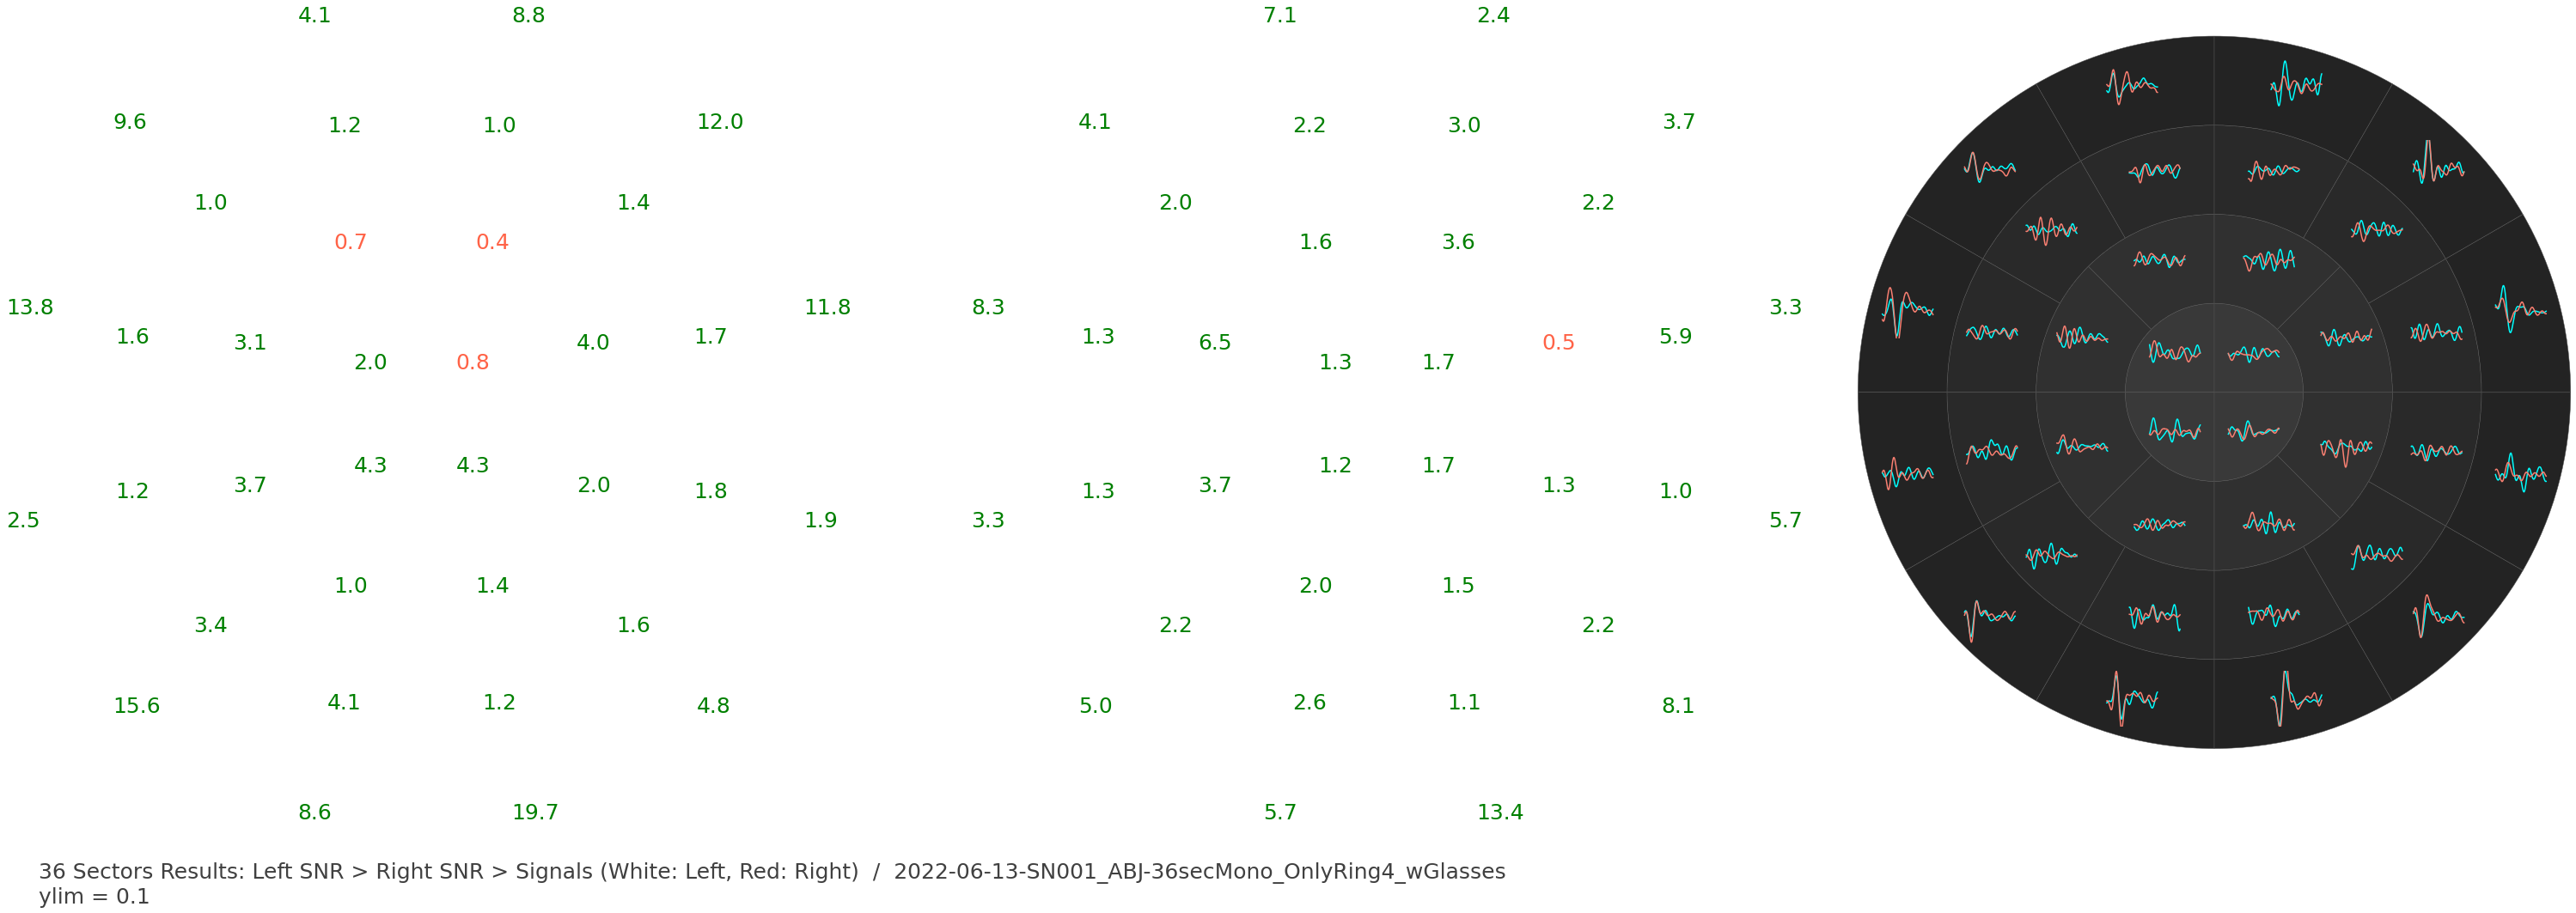

In [9]:
# ------------------------- #
# mfVEP1 Signal Processing: #
# ------------------------- #

snr_sig_win   = [45, 150]
snr_noise_win = [325, 430]
n_sec        = 36
plot_region   = range(500) # [0, 250]

# 1. Adjusting the polarities of the signals
l_sig_i = fix_polarity(l_vep_sig_fr)
r_sig_i = fix_polarity(r_vep_sig_fr)

# 2. Aligning the phase of the signals
l_sig_ii, l_shift=align_signals(l_sig_i)
r_sig_ii, r_shift=align_signals(r_sig_i)

# 3. getting average and calculating the SNRs: (mode=snr_weighted)
l_sig_iii, l_sig_snr, _ = w_ave_and_snr(l_sig_ii, snr_sig_win=snr_sig_win.copy(), snr_noise_win=snr_noise_win.copy())
r_sig_iii, r_sig_snr, _ = w_ave_and_snr(r_sig_ii, snr_sig_win=snr_sig_win.copy(), snr_noise_win=snr_noise_win.copy())

# 4. Plotting the Result:
plot_region   = range(500)
l_vep_sig = l_sig_iii
r_vep_sig = r_sig_iii


l_snr    = l_sig_snr.copy() # These should have a shape of 1X12
r_snr    = r_sig_snr.copy()

fig_width   = 3
fig_height  = 3
ylim        = 0.1#max(abs(l_vep_sig).max(), abs(r_vep_sig).max()) # 0.15  OR: max(abs(l_vep_sig).max(), abs(r_vep_sig).max())
axis_inc_x  = np.array([[4,  0, 0, 0]]*n_sec)
axis_inc_y  = np.array([[0, -2.5, 0, 0]]*n_sec)
resp_window = [0, 500]  # 45, 150 [ms] [0, 105]

# 4.1. Left SNRs:
fig = plt.figure(figsize=(fig_width, fig_height))
for i in range(n_sec):
    ax = fig.add_axes(axis_locs_36[i])
    if (l_snr[i]>1):
        ax.text(axis_locs_36[i][0], axis_locs_36[i][1], np.around(l_snr[i], 1), fontsize=25, color='green')
        ax.axis('off')
    else:
        ax.text(axis_locs_36[i][0], axis_locs_36[i][1], np.around(l_snr[i], 1), fontsize=25, color='tomato')
        ax.axis('off')  
    

# 4.2. Right SNRs:
 
for i in range(n_sec):
    ax = fig.add_axes(axis_locs_36[i] + axis_inc_x[i])
    if (r_snr[i]>1):
        ax.text(axis_locs_36[i][0]+axis_inc_x[i][0], axis_locs_36[i][1]+axis_inc_x[i][1], np.around(r_snr[i], 1), fontsize=25, color='green')
        ax.axis('off')
    else:
        ax.text(axis_locs_36[i][0]+axis_inc_x[i][0], axis_locs_36[i][1]+axis_inc_x[i][1], np.around(r_snr[i], 1), fontsize=25, color='tomato')
        ax.axis('off')    
    

    
    
# 4.3. Signal-Grid plot w/ 12 channels RIGHT ON LEFT:

ax = fig.add_axes([2.4*4, 0, 0.3, 0.3])
ax.axis('equal')
ring1, _ = ax.pie(ring1_sectors, radius=4 , colors=[greys(0.82)]*4, startangle=90)#, labels=range(0, 4), labeldistance=.5, counterclock=False, startangle=90)
plt.setp(ring1, width=4, edgecolor=greys(0.75))
ring2, _ = ax.pie(ring2_sectors, radius=8 , colors=[greys(0.84)]*8, startangle=90)#, labels=range(0, 4), labeldistance=.5, counterclock=False, startangle=90)
plt.setp(ring2, width=4, edgecolor=greys(0.75))
ring3, _ = ax.pie(ring3_sectors, radius=12 , colors=[greys(0.86)]*12, startangle=90)#, labels=range(0, 4), labeldistance=.5, counterclock=False, startangle=90)
plt.setp(ring3, width=4, edgecolor=greys(0.75))
ring4, _ = ax.pie(ring3_sectors, radius=16 , colors=[greys(0.88)]*12, startangle=90)#, labels=range(0, 4), labeldistance=.5, counterclock=False, startangle=90)
plt.setp(ring4, width=4, edgecolor=greys(0.75))
for i in range(n_sec):
    ax = fig.add_axes(axis_locs_36[i] + 2.4*axis_inc_x[i])
    ax.plot(l_vep_sig[i, plot_region], 'cyan')
    ax.plot(r_vep_sig[i, plot_region], 'salmon')
    ax.axis('off') # remove frame around plots
    ax.set_ylim(-ylim, ylim)
    ax.axis('off')
    
    
ax = fig.add_axes([-2, -2.6, .3, .3])
ax.text(0.1, 0, '36 Sectors Results: Left SNR > Right SNR > Signals (White: Left, Red: Right)  /  ' + TEST + '\nylim = ' + str(ylim), fontsize=25, color=greys(0.8))
ax.axis('off');
        

#fig.savefig(results_path + '\\' + TEST[17:21] + ' - 36 Sectors Results-_VAR-lvl5AN-IIR3_50-w_o new ave method (fixed hood chs).png', dpi=300, bbox_inches='tight', facecolor='w')